In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import torch
import random
import numpy as np
from tqdm import tqdm

def load_image(path, size):
    image = image2tensor(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))

    w, h = image.shape[-2:]
    if w != h:
        crop_size = min(w, h)
        left = (w - crop_size)//2
        right = left + crop_size
        top = (h - crop_size)//2
        bottom = top + crop_size
        image = image[:,:,left:right, top:bottom]

    if image.shape[-1] != size:
        image = torch.nn.functional.interpolate(image, (size, size), mode="bilinear", align_corners=True)
    
    return image

def image2tensor(image):
    image = torch.FloatTensor(image).permute(2,0,1).unsqueeze(0)/255.
    return (image-0.5)/0.5

def tensor2image(tensor):
    tensor = tensor.clamp(-1., 1.).detach().squeeze().permute(1,2,0).cpu().numpy()
    return tensor*0.5 + 0.5

def imshow(img, size=5, cmap='jet'):
    plt.figure(figsize=(size,size))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

def horizontal_concat(imgs):
    return torch.cat([img.unsqueeze(0) for img in imgs], 3) 

device = 'cuda:0'
image_size = 256
torch.set_grad_enabled(False)

### Load Swap AE

In [2]:
from model import Encoder, Generator

ae_model_path = './checkpoint/002000.pt'
        
encoder = Encoder(32).to(device)
generator = Generator(32).to(device)

ckpt = torch.load(ae_model_path, map_location=device)
encoder.load_state_dict(ckpt["e_ema"])
generator.load_state_dict(ckpt["g_ema"])

encoder.eval()
generator.eval()

print(f'[SwapAE model loaded] {ae_model_path}')

[SwapAE model loaded] ./checkpoint/002000.pt


### Load StyleGAN2 generator

[StyleGAN2 generator loaded] ./checkpoint/stylegan2-naverwebtoon-800k.pt

StyleGAN2 generated images:


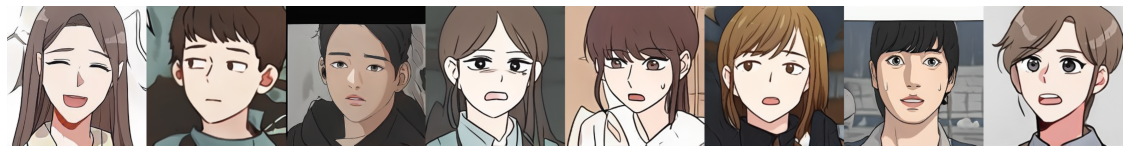

SwapAE reconstructions:


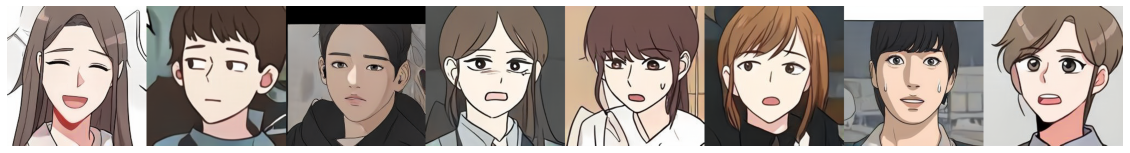

Swapping results:


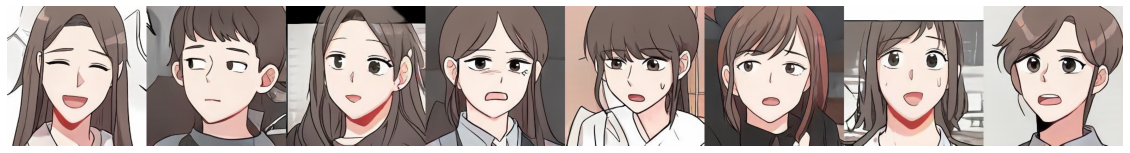

In [3]:
from stylegan2.model import Generator as StyleGAN

stylegan_model_path = './checkpoint/stylegan2-naverwebtoon-800k.pt'
stylegan_ckpt = torch.load(stylegan_model_path, map_location=device)

latent_dim = stylegan_ckpt['args'].latent

stylegan = StyleGAN(image_size, latent_dim, 8).to(device)
stylegan.load_state_dict(stylegan_ckpt["g_ema"], strict=False)
stylegan.eval()
print(f'[StyleGAN2 generator loaded] {stylegan_model_path}\n')

truncation = 0.7
trunc = stylegan.mean_latent(4096).detach().clone()

num_samples = 8

latent = stylegan.get_latent(torch.randn(num_samples, latent_dim, device=device))
imgs_gen, _ = stylegan([latent],
                        truncation=truncation,
                        truncation_latent=trunc,
                        input_is_latent=True,
                        randomize_noise=True)

print("StyleGAN2 generated images:")
imshow(tensor2image(horizontal_concat(imgs_gen)), size=20)

structures, textures = encoder(imgs_gen)
recon_results = generator(structures, textures)

print("SwapAE reconstructions:")    
imshow(tensor2image(horizontal_concat(recon_results)), size=20)

print("Swapping results:")    
swap_results = generator(structures, textures[0].unsqueeze(0).repeat(num_samples,1))
imshow(tensor2image(horizontal_concat(swap_results)), size=20)



### Face2Webtoons

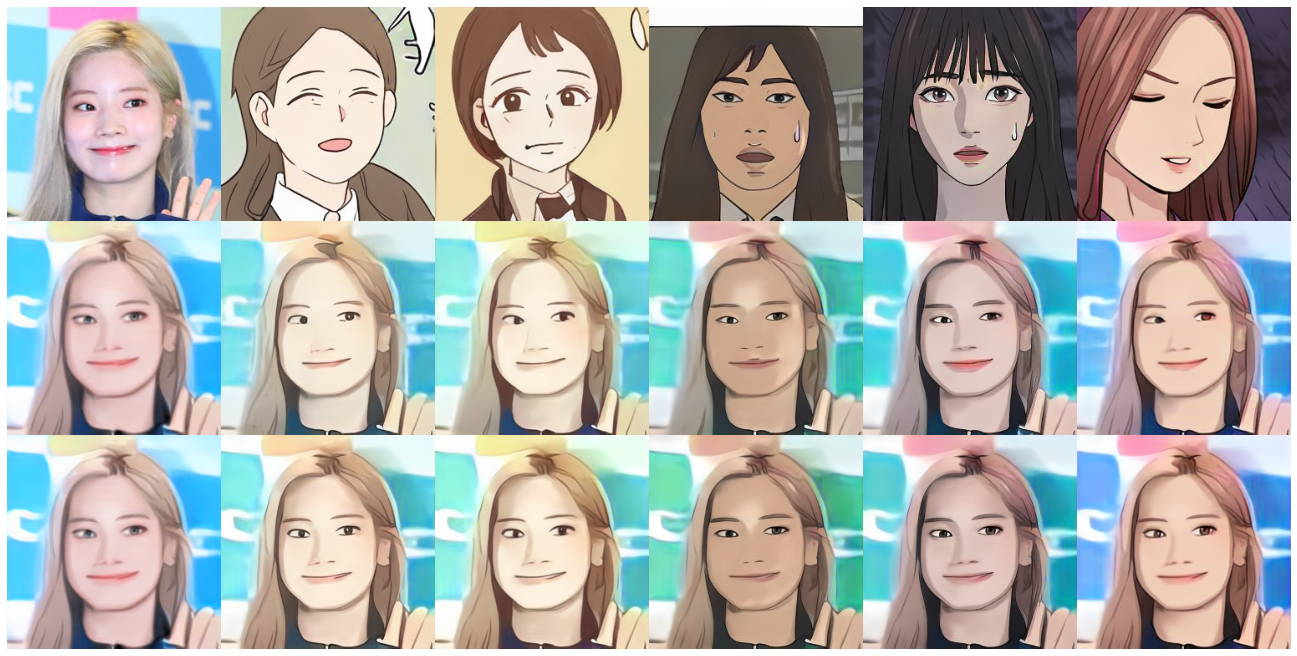

True

In [4]:
test_image_path = "./inputs/1.jpg"
test_image = load_image(test_image_path, image_size)

num_styles = 5

latent = stylegan.get_latent(torch.randn(num_styles, latent_dim, device=device))
imgs_gen, _ = stylegan([latent],
                        truncation=truncation,
                        truncation_latent=trunc,
                        input_is_latent=True,
                        randomize_noise=True)

inputs = torch.cat([test_image.to(device), imgs_gen])

results = horizontal_concat(inputs.cpu())

structures, target_textures = encoder(inputs)

structure = structures[0].unsqueeze(0).repeat(len(target_textures),1,1,1)
source_texture = target_textures[0].unsqueeze(0).repeat(len(target_textures),1)

for swap_loc in [3, 5]:
    textures = [source_texture for _ in range(swap_loc)] + [target_textures for _ in range(len(generator.layers) - swap_loc)]        
    fake_imgs = generator(structure, textures, noises=0)

    results = torch.cat([results, horizontal_concat(fake_imgs).cpu()], dim=2)
        
imshow(tensor2image(results), 23)

cv2.imwrite('./results/1.jpg', cv2.cvtColor(255*tensor2image(results), cv2.COLOR_BGR2RGB))

### Style Exploration (GIF)

In [7]:
import imageio
        
swap_loc = 5

num_anchors = 10
num_interp = 20
anchors = stylegan.get_latent(torch.randn(num_anchors, 512, device=device))

photo_input = test_image.to(device)
ori_structure, ori_textures = encoder(photo_input)
    
black_image = torch.zeros_like(test_image)

with imageio.get_writer('results/exploration.gif', mode='I', duration=0.05, palettesize=256, subrectangles=False) as writer:
    
    for i in tqdm(range(num_anchors-1)):
        initial = anchors[i]
        final = anchors[i+1]

        for j in range(num_interp):
            latent = (float(num_interp-j) * initial + float(j) * final)/num_interp

            gen_img, _ = stylegan([latent],
                                   truncation=truncation,
                                   truncation_latent=trunc,
                                   input_is_latent=True,
                                   randomize_noise=True)

            _, target_texture = encoder(gen_img)
            textures = [ori_textures for _ in range(swap_loc)] + [target_texture for _ in range(len(generator.layers) - swap_loc)]
            swap_img = generator(ori_structure, textures, noises=0)

            result = torch.cat([black_image, gen_img.cpu()], 3)
            result = torch.cat([
                result,
                torch.cat([test_image, swap_img.cpu()], 3)
            ], 2)
            
            writer.append_data((tensor2image(result)*255).astype(np.uint8))


100%|██████████| 9/9 [00:50<00:00,  5.65s/it]
